## Init

In [2]:
! pip3 install gym
! pip3 install atari-py
! pip3 install torch

In [0]:
import gym
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from tqdm import tqdm
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

## Modules

In [0]:
class PolicyNetwork(nn.Module):
  def __init__(self, state_size=4, action_size=2):
    super(PolicyNetwork, self).__init__()
    self.state_size = state_size
    self.action_size = action_size
    
    self.net = nn.Sequential(nn.Linear(self.state_size, 10),
                             nn.ReLU(),
                             nn.Linear(10, 10),
                             nn.ReLU(),
                             nn.Linear(10, 10),
                             nn.ReLU(),
                             nn.Linear(10, self.action_size),
                             nn.Softmax(dim=1))
  
  def forward(self, x):
    return self.net(x)
  
  
class ValueNetwork(nn.Module):
  def __init__(self, state_size=4):
    super(ValueNetwork, self).__init__()
    self.state_size = state_size
  
    self.net = nn.Sequential(nn.Linear(self.state_size, 10),
                             nn.ReLU(),
                             nn.Linear(10, 10),
                             nn.ReLU(),
                             nn.Linear(10, 10),
                             nn.ReLU(),
                             nn.Linear(10, 1))
    
  def forward(self, x):
    return self.net(x)
  
  
class PpoDataset(Dataset):
  def __init__(self, data):
    super(PpoDataset, self).__init__()
    self.data = []
    for d in data:
      self.data.extend(d)
  
  def __getitem__(self, index):
    return self.data[index]
 
  def __len__(self):
    return len(self.data)

## Methods

In [0]:
def calculate_returns(rollouts, gamma):
  for rollout in rollouts:
    discounted = 0
    for i in reversed(range(len(rollout))):
      discounted = gamma * discounted + rollout[i]["reward"]
      rollout[i]["return"] = discounted

In [0]:
def train(env, policy, value, optim, value_objective, epochs, env_samples, 
          episode_length, gamma, policy_epochs, batch_size, epsilon, 
          c_value, c_policy):
  try:
    returns = []
    loop = tqdm(total=epochs, position=0, leave=False)
    for epoch in range(epochs):
      # generate rollouts
      rollouts = []
      frames = []
      standing_len = 0
      for episode in range(env_samples):
        state = env.reset()
        done = False
        rollout = []
        total_reward = 0

        for step in range(1, episode_length + 1):
          step = {}
          state_torch = torch.FloatTensor(state).unsqueeze(0)
          action_dist = policy(state_torch)
          action_dist = action_dist[0].detach().numpy()
          action = np.argmax(np.random.multinomial(1, action_dist))
          state_p, r, done, _ = env.step(action)
          
          step["state"] = state
          step["reward"] = r
          step["action_dist"] = action_dist
          step["action"] = action

          total_reward += 1
          rollout.append(step)
          if done: break

          state = state_p

        rollouts.append(rollout)
        if total_reward == 200:
          print("episodes: ", epoch * env_samples + episode)

      calculate_returns(rollouts, gamma)
      returns.append(sum([sum([s["return"] for s in r]) / len(r) for r in rollouts]) / len(rollouts))

      # Approximate the value and policy
      dataset = PpoDataset(rollouts)
      loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
      for _ in range(policy_epochs):
        for step in loader:
          optim.zero_grad()

          state = step["state"].float()
          ret = step["return"].float().unsqueeze(1)
          est_return = value(state)
          advantage = ret - est_return
          value_loss = c_value * value_objective(est_return, ret)

          advantage.detach_()
          action_dist = policy(state)
          cur = action_dist[range(action_dist.shape[0]), step["action"]].unsqueeze(1)
          old = step["action_dist"][range(step["action_dist"].shape[0]), step["action"]].unsqueeze(1)
          ratio = cur / old
          left = ratio * advantage
          right = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantage
          policy_loss = c_policy * -torch.mean(torch.min(left, right))

          loss = value_loss + policy_loss
          loss.backward()
          optim.step()

      loop.update(1)
      loop.set_description('Epoch:{}, Return:{:.4f}, Value Loss:{:.4f}, Policy Loss:{:.4f}'
        .format(epoch, returns[-1], value_loss, policy_loss))
  except:
    __ITB__()
  return returns
      

## Main

In [26]:
env = gym.make('CartPole-v0')
policy = PolicyNetwork(4, 2)
value = ValueNetwork(4)

optim = torch.optim.Adam(chain(policy.parameters(), value.parameters()), lr=1e-3, betas=(0.9, 0.999))
value_objective = nn.MSELoss()

# Hyperparameters
epochs = 50
env_samples = 100
episode_length = 200
gamma = 0.9
policy_epochs = 5
batch_size = 256
epsilon = 0.2
c_value = 1
c_policy = 1

returns1 = train(env, policy, value, optim, value_objective, epochs, env_samples, 
                 episode_length, gamma, policy_epochs, batch_size, epsilon, 
                 c_value, c_policy)

Epoch:7, Return:7.6671, Value Loss:4.9976, Policy Loss:-0.1276:  16%|█▌        | 8/50 [00:07<00:49,  1.18s/it]

episodes:  812
episodes:  896


Epoch:8, Return:8.4750, Value Loss:1.6631, Policy Loss:-0.3529:  18%|█▊        | 9/50 [00:10<01:06,  1.62s/it]

episodes:  915
episodes:  922
episodes:  923
episodes:  931
episodes:  933
episodes:  938
episodes:  941
episodes:  946
episodes:  949
episodes:  955
episodes:  956
episodes:  968
episodes:  971
episodes:  976
episodes:  988
episodes:  992
episodes:  998
---------------------------------------------------------------------------
KeyboardInterrupt                         Traceback (most recent call last)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py in __call__(self=PolicyNetwork(
  (net): Sequential(
    (0): Lin...t_features=2, bias=True)
    (7): Softmax()
  )
), *input=(tensor([[-0.8371, -1.2260, -0.1399, -0.0414]]),), **kwargs={})
    487             result = self._slow_forward(*input, **kwargs)
    488         else:
--> 489             result = self.forward(*input, **kwargs)
        result = undefined
        self.forward = <bound method PolicyNetwork.forward of PolicyNetwork(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (

In [0]:
env = gym.make('Centipede-ram-v0')
policy = PolicyNetwork(128, 18)
value = ValueNetwork(128)

optim = torch.optim.Adam(chain(policy.parameters(), value.parameters()), lr=1e-3, betas=(0.9, 0.999))
value_objective = nn.MSELoss()

# Hyperparameters
epochs = 50
env_samples = 100
episode_length = 500
gamma = 0.9
policy_epochs = 5
batch_size = 256
epsilon = 0.2
c_value = 1
c_policy = 100

returns2 = train(env, policy, value, optim, value_objective, epochs, env_samples, 
                 episode_length, gamma, policy_epochs, batch_size, epsilon,
                 c_value, c_policy)

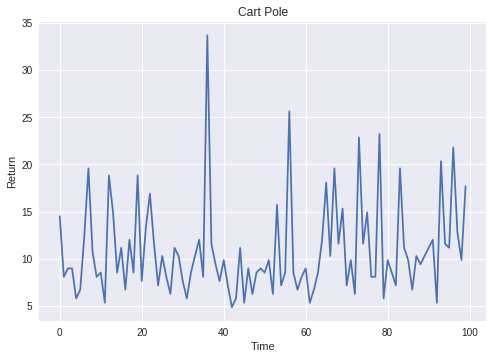

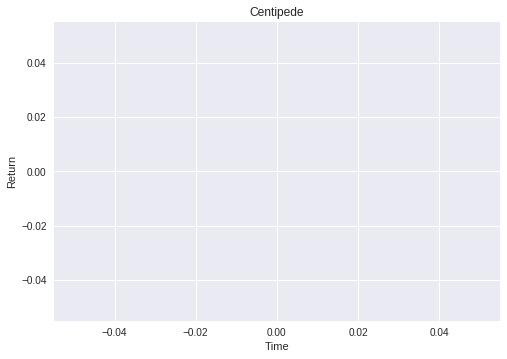

In [13]:
# Plot results
plt.plot(returns1)
plt.title("Cart Pole")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()

plt.plot(returns2)
plt.title("Centipede")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()